In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

In [2]:
cap = cv.VideoCapture("data/0001-0030.avi")

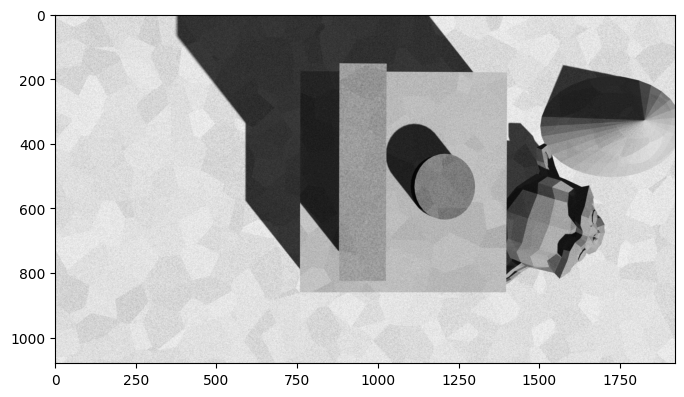

In [3]:
ret, first_frame = cap.read()
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255
plt.imshow(prev_gray, cmap='gray')

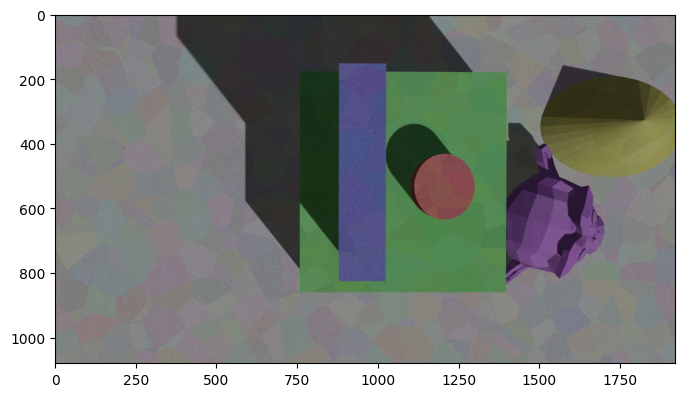

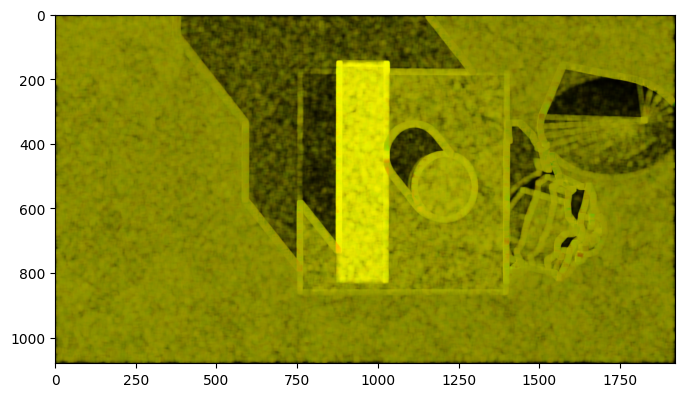

In [4]:

ret, frame = cap.read()
plt.imshow(frame), plt.show()
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
flow = cv.calcOpticalFlowFarneback(
    prev=prev_gray,
    next=gray, 
    flow=None,
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
mask[..., 0] = angle * 180 / np.pi / 2
mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
plt.imshow(rgb)

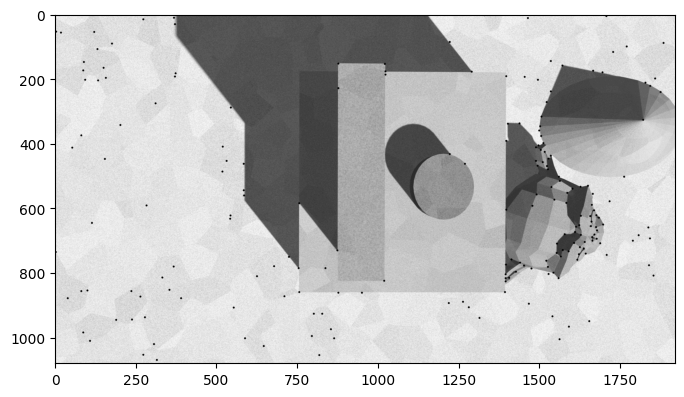

(<matplotlib.image.AxesImage at 0x2761e0f4bd0>, None)

In [5]:
ret, img = cap.read()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(gray,200,0.01,10)
corners = np.intp(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(gray,(x,y),3,(255,0,0),-1)

ret, next_img = cap.read()
next_gray = cv.cvtColor(next_img,cv.COLOR_BGR2GRAY)
next_corners = cv.goodFeaturesToTrack(next_gray,200,0.01,10)
next_corners = np.intp(next_corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(gray,(x,y),3,(0,255,0),-1)
plt.imshow(gray, cmap='gray'),plt.show()

In [6]:
cost = np.zeros((len(corners), len(next_corners)))
cost.size

40000

In [7]:
for c, corner in enumerate(corners):
    for n, next_corner in enumerate(next_corners):
        cost[c][n] = np.linalg.norm(corner - next_corner)

In [8]:
from scipy.optimize import linear_sum_assignment

In [9]:
row_ind, col_ind = linear_sum_assignment(cost)

In [10]:
cost[row_ind, col_ind].sum()

8163.307431664431

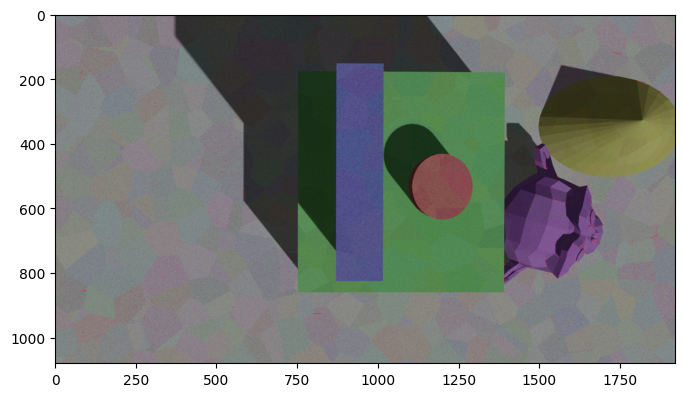

In [11]:
for r, c in zip(row_ind, col_ind):
    if cost[r, c] < 30:
        cv.line(next_img, *corners[r], *next_corners[c], (255,0,0), 1)
plt.imshow(next_img)

In [12]:
len(row_ind), len(col_ind)

(200, 200)

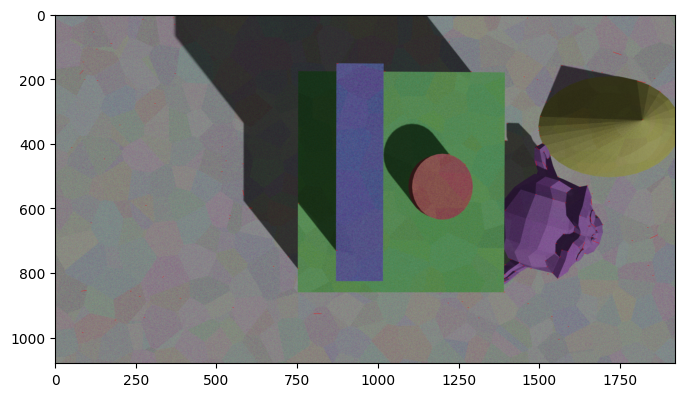

In [13]:
cv.line(next_img, (600,600), (610,600), (255,0,0), 1)
plt.imshow(next_img)

In [14]:
cap = cv.VideoCapture("data/0001-0030.avi")
ret, first_frame = cap.read()
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255

ret, frame = cap.read()
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                    None,
                                    0.5, 3, 15, 3, 5, 1.2, 0)